# Learning keypoints



## Downloading project, weights and dataset

In [1]:
!git clone https://github.com/karlosos/camera_calib
!mkdir models
!wget https://storage.googleapis.com/narya-bucket-1/models/keypoint_detector.h5 -O models/keypoint_detector.h5
!wget https://storage.googleapis.com/narya-bucket-1/dataset/keypoints_dataset.zip
!unzip keypoints_dataset.zip -d data_keypoints/
!rm ./data_keypoints/data_keypoints/.DS_Store
!rm ./data_keypoints/data_keypoints/test/.DS_Store
!rm ./data_keypoints/data_keypoints/test/Annotations/.DS_Store
!rm ./data_keypoints/data_keypoints/train/.DS_Store
!rm ./data_keypoints/data_keypoints/train/Annotations/.DS_Store
!rm ./data_keypoints/data_keypoints/train/JPEGImages/.DS_Store
!cd camera_calib && pip3 install -r requirements.txt
!pip install -e ./camera_calib/
!pip install git+https://github.com/qubvel/classification_models.git

Cloning into 'camera_calib'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 62 (delta 14), reused 56 (delta 8), pack-reused 0
Unpacking objects: 100% (62/62), done.
--2021-02-24 11:31:28--  https://storage.googleapis.com/narya-bucket-1/models/keypoint_detector.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56671328 (54M) [application/octet-stream]
Saving to: ‘models/keypoint_detector.h5’

models/keypoint_det 100%[===================>]  54.05M  69.4MB/s    in 0.8s    

2021-02-24 11:31:29 (69.4 MB/s) - ‘models/keypoint_detector.h5’ saved [56671328/56671328]

--2021-02-24 11:31:29--  https://storage.googleapis.com/narya-bucket-1/dataset/keypoints_dataset.zip
Resolving s

## Download my dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!cp /content/gdrive/MyDrive/camera_calib/dataset_02.zip ./dataset_02.zip
!unzip dataset_02.zip -d dataset_02/

Archive:  dataset_02.zip
   creating: dataset_02/test/
   creating: dataset_02/test/Annotations/
  inflating: dataset_02/test/Annotations/BaltykKonin (109).xml  
  inflating: dataset_02/test/Annotations/BaltykKonin (110).xml  
  inflating: dataset_02/test/Annotations/BaltykKonin (121).xml  
  inflating: dataset_02/test/Annotations/BaltykKonin (13).xml  
  inflating: dataset_02/test/Annotations/BaltykKonin (27).xml  
  inflating: dataset_02/test/Annotations/BaltykKonin (28).xml  
  inflating: dataset_02/test/Annotations/BaltykKonin (34).xml  
  inflating: dataset_02/test/Annotations/BaltykKonin (47).xml  
  inflating: dataset_02/test/Annotations/BaltykKonin (49).xml  
  inflating: dataset_02/test/Annotations/BaltykKonin (73).xml  
  inflating: dataset_02/test/Annotations/BaltykKonin (86).xml  
  inflating: dataset_02/test/Annotations/BaltykKonin (94).xml  
  inflating: dataset_02/test/Annotations/BaltykKonin (99).xml  
  inflating: dataset_02/test/Annotations/BaltykStarogard (11).xml  


## Training keypoints

As we have downloaded files and unzipped them we can start learning model.

In [4]:
!python camera_calib/camera_calib/trainer/keypoints_train.py --data_dir "./dataset_02/" --weights "./models/keypoint_detector.h5" --batch_size 8 

Using TensorFlow backend.
Segmentation Models: using `keras` framework.
----------
Building model
----------
Saving the best model weights to FPN_efficientnetb3_0.0001_8.h5
2021-02-24 11:45:31.721659: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-02-24 11:45:31.779628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-24 11:45:31.780285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-02-24 11:45:31.785232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-02-24 11:45:32.005612: I tensorflow/strea

## Test DeepHomoModel

In [7]:
import cv2
# Load model
from camera_calib.camera_calib.models.keras_models import KeypointDetectorModel

kp_model = KeypointDetectorModel(
    backbone='efficientnetb3', num_classes=29, input_shape=(320, 320),
)

WEIGHTS_NAME = "FPN_efficientnetb3_0.0001_8.h5"
kp_model.load_weights(WEIGHTS_NAME)

# Load template
template = cv2.imread('camera_calib/resources/world_cup_template.png')
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (1280,720))/255.

from camera_calib.camera_calib.utils.vizualization import rgb_template_to_coord_conv_template

template = rgb_template_to_coord_conv_template(template)

Succesfully loaded weights from FPN_efficientnetb3_0.0001_8.h5


In [13]:
from camera_calib.camera_calib.utils.image import denormalize
import numpy as np
import cv2
from matplotlib import pyplot as plt

from camera_calib.camera_calib.utils.vizualization import visualize
from camera_calib.camera_calib.utils.masks import _points_from_mask 
from camera_calib.camera_calib.utils.homography import get_perspective_transform
from camera_calib.camera_calib.utils.homography import warp_image
from camera_calib.camera_calib.utils.vizualization import merge_template
from camera_calib.camera_calib.utils.vizualization import visualize

def load_image(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

def calculate_keypoints_mask(image, kp_model):
  pr_mask = kp_model(image)
  # visualize(
  #         image=denormalize(image.squeeze()),
  #         pr_mask=pr_mask[..., -1].squeeze(),
  #     )
  return pr_mask

def homography_viz(image, pr_mask, template):
  src,dst = _points_from_mask(pr_mask[0])
  pred_homo = get_perspective_transform(dst,src)
  pred_warp = warp_image(cv2.resize(template, (320,320)),pred_homo,out_shape=(320,320))
  visualize(
          image=denormalize(image.squeeze()),
          warped_homography=pred_warp,
      )

  test = merge_template(image/255.,cv2.resize(pred_warp, (image.shape[1], image.shape[0])))
  visualize(image = test)
  return pred_homo

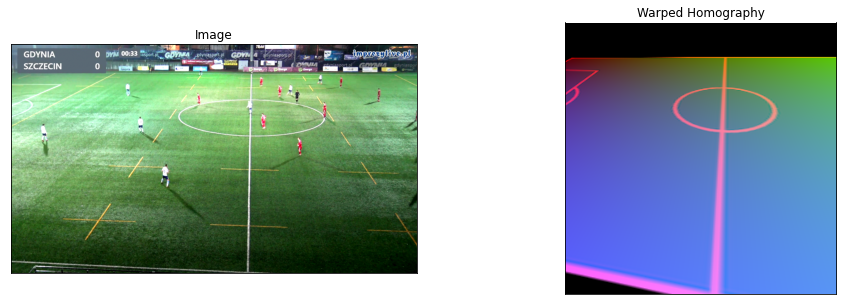

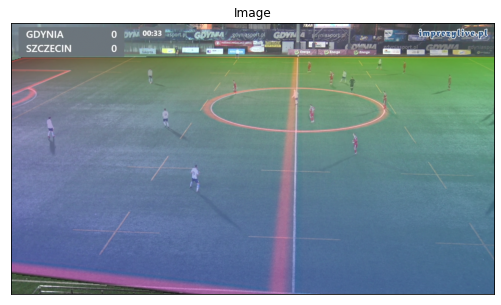

array([[ 9.69577137e-01, -3.92040816e-01,  8.26300949e+00],
       [-3.84615810e-02,  1.12621073e-01,  4.15093280e+01],
       [-8.38467045e-04, -2.03702627e-03,  1.00000000e+00]])

In [14]:
image = load_image('BaltykSwit (1).jpg')
pr_mask = kp_model(image)
homography_viz(image, pr_mask, template)

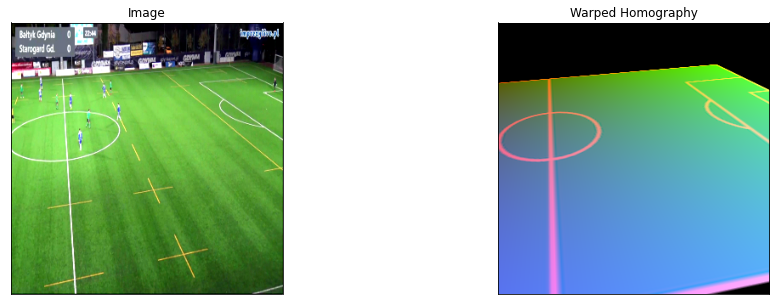

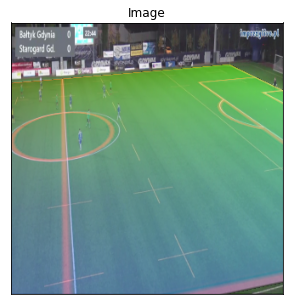

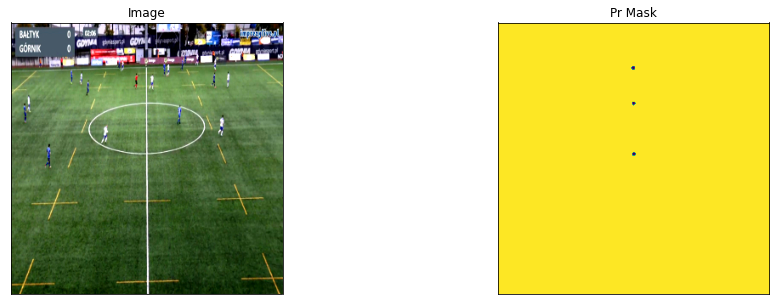

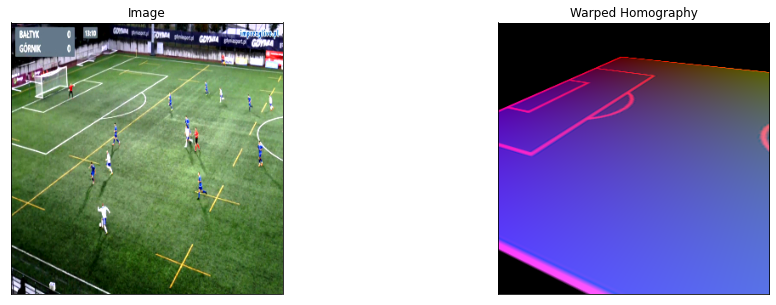

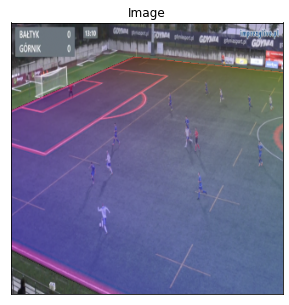

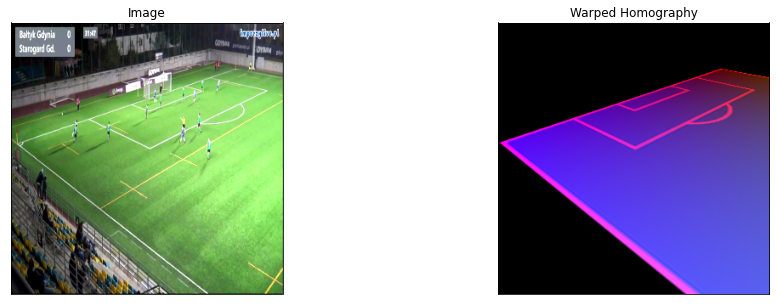

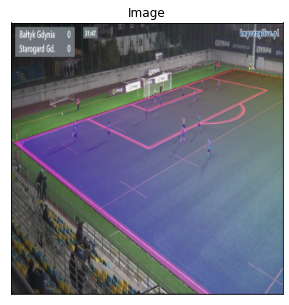

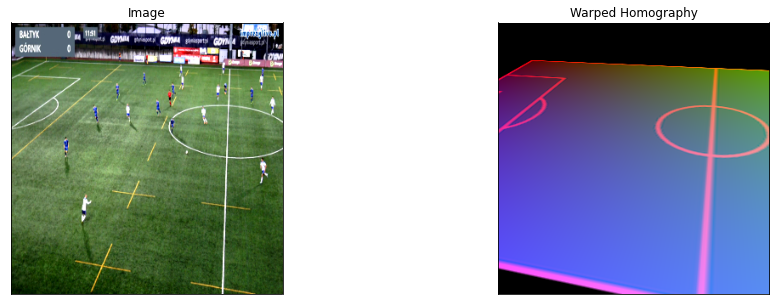

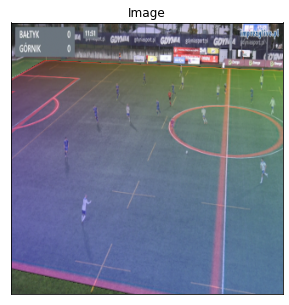

In [18]:
import os
test_images = os.listdir("dataset_02/test/JPEGImages")

for image_path in test_images[:5]:
  image_path = "dataset_02/test/JPEGImages/" + image_path
  image = load_image(image_path)
  pr_mask = kp_model(image)
  try:
    homography_viz(image, pr_mask, template)
  except:
    visualize(
        image=denormalize(image.squeeze()),
        pr_mask=pr_mask[..., -1].squeeze(),
    )
  

## Zapisanie modelu

In [5]:
!cp FPN_efficientnetb3_0.0001_8.h5 /content/gdrive/MyDrive/camera_calib/FPN_efficientnetb3_0.0001_8_427.h5